In [1]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from pathlib import Path
import os

# Set up paths
PYTHONPATH = "/global/homes/b/bpb/repos/envnet"
os.environ['PYTHONPATH'] = PYTHONPATH

# Import ENVnet
import sys
sys.path.insert(0, PYTHONPATH)
from envnet.build import quick_envnet
from envnet.config.build_config import BuildConfig
from envnet.build import ENVnetBuilder

output_dir = Path(os.path.join(PYTHONPATH, "results", "temp_data"))
output_dir.mkdir(parents=True, exist_ok=True)

# Create config
config = BuildConfig()
config.min_score = 0.7  # Lower threshold for testing
config.remblink_cutoff = 0.025
config.network_max_mz_difference = 5000.0
config.min_cluster_size = 2


In [2]:
# use recursive find to get all parquet files
# use linux find since it is much faster than glob
cmd = "find /global/cfs/cdirs/metatlas/projects/envnet_build_files/ -name '*_deconvoluted.parquet'"
# run command
import subprocess
result = subprocess.run(cmd, shell=True, capture_output=True, text=True)
files = result.stdout.splitlines()
len(files)

1401

In [3]:
import os
for f in files:
    mzml_filename = f.replace("_deconvoluted.parquet", ".mzML")
    h5_filename = f.replace("_deconvoluted.parquet", ".h5")
    if not os.path.exists(mzml_filename):
        print(f)
    if not os.path.exists(h5_filename):
        print(f)

In [4]:
# import shutil
# path_to_replace = '/global/cfs/cdirs/metatlas/projects/carbon_network/raw_data'
# path_replace_with = '/global/cfs/cdirs/metatlas/projects/envnet_build_files'
# for f in files:
#     mzml_filename = f.replace("_deconvoluted.parquet", ".mzML")
#     h5_filename = f.replace("_deconvoluted.parquet", ".h5")
#     new_mzml_filename = mzml_filename.replace(path_to_replace, path_replace_with)
#     new_h5_filename = h5_filename.replace(path_to_replace, path_replace_with)
#     # copy the mzml and h5 file from the original path to the new path
#     # make the sub directories
#     os.makedirs(os.path.dirname(new_mzml_filename), exist_ok=True)
#     shutil.copy(mzml_filename, new_mzml_filename)
#     shutil.copy(h5_filename, new_h5_filename)


In [5]:
df = []
for parquet_file in files:
    temp_df = pd.read_parquet(parquet_file)
    df.append(temp_df)

df = pd.concat(df, ignore_index=True)
df.reset_index(drop=True, inplace=True)

In [6]:
# # parquet_file = '/global/cfs/cdirs/metatlas/projects/carbon_network/raw_data/metatlas/20220707_JGI_SB_503799_Permafrost_pilot_QE-HF_C18_USDAY63663_NEG_MSMS_10_55M-Subsection-MeOH_1_Rg80to1200-CE102040-soil-S1_Run26_deconvoluted.parquet'
# # print(f"Loading: {parquet_file}")
# # df = pd.read_parquet(parquet_file)


# import glob
# files1 = glob.glob('/global/cfs/cdirs/metatlas/projects/carbon_network/raw_data/metatlas/20220707_JGI_SB_503799_*_deconvoluted.parquet')
# files2 = glob.glob('/global/cfs/cdirs/metatlas/projects/carbon_network/raw_data/massive/v06/MSV000092520/peak/*_deconvoluted.parquet')
# files3 = glob.glob('/global/cfs/cdirs/metatlas/projects/carbon_network/raw_data/metatlas/20240112_JGI_MdR_109570-002_OMTSoil50g_Pilot_QEHF_C18_USDAY86082_NEG_MS2_1_soil-*_deconvoluted.parquet')
# files = files1 + files2 + files3
# df = []

# for parquet_file in files:
#     print(f"Loading: {parquet_file}")
#     temp_df = pd.read_parquet(parquet_file)
#     df.append(temp_df)

# df = pd.concat(df, ignore_index=True)
# df.reset_index(drop=True, inplace=True)

In [7]:



print(f"Total spectra in file: {len(df)}")
print(f"Columns: {list(df.columns)}")
print(f"Precursor m/z range: {df['precursor_mz'].min():.3f} - {df['precursor_mz'].max():.3f}")

df.rename(columns={
    'mdm_mz_vals': 'deconvoluted_spectrum_mz_vals',
    'mdm_i_vals': 'deconvoluted_spectrum_intensity_vals',
    'original_mz_vals':'original_spectrum_mz_vals',
    'original_i_vals':'original_spectrum_intensity_vals'
}, inplace=True)

df['basename'] = df['filename'].apply(lambda x: os.path.basename(x))

df.head()


Total spectra in file: 4752219
Columns: ['temp_index', 'rt', 'count', 'precursor_mz', 'sum_frag_intensity', 'max_frag_intensity', 'obs', 'isolated_precursor_mz', 'filename', 'basename', 'coisolated_precursor_count', 'coisolated_precursor_mz_list', 'assumed_adduct', 'predicted_formula', 'estimated_fdr', 'deconvoluted_spectrum_mz_vals', 'deconvoluted_spectrum_intensity_vals', 'original_spectrum_mz_vals', 'original_spectrum_intensity_vals']
Precursor m/z range: 81.035 - 1421.999


,temp_index,rt,count,precursor_mz,sum_frag_intensity,max_frag_intensity,obs,isolated_precursor_mz,filename,basename,coisolated_precursor_count,coisolated_precursor_mz_list,assumed_adduct,predicted_formula,estimated_fdr,deconvoluted_spectrum_mz_vals,deconvoluted_spectrum_intensity_vals,original_spectrum_mz_vals,original_spectrum_intensity_vals
0,1,1.005395,5,117.008723,21028.255005,13034.295898,"[C2H3NO2, SO2, C2H4O, CO2, C2H2O]",116.928307,/global/cfs/cdirs/metatlas/projects/envnet_bui...,20230403_EB_BGS_107002-011_BIODESERT_Metagenom...,1,[117.00872302783414],[M-H]-,C6H2N2O,0.000000e+00,"[43.998882, 53.04045, 72.88191, 73.02972, 75.0...","[13034.296, 1214.0403, 1347.6383, 2157.2583, 3...","[132.6867, 117.02777, 116.93878, 116.928535, 1...","[1470.3018, 9307.385, 2642.6677, 36962.4, 1915..."
1,2,1.017603,3,117.016451,17914.224121,12712.428711,"[C2H3NO2, CO2, C2H2O]",116.928329,/global/cfs/cdirs/metatlas/projects/envnet_bui...,20230403_EB_BGS_107002-011_BIODESERT_Metagenom...,1,[117.01645147063245],[M-H]-,H2N6O2,0.000000e+00,"[43.998905, 73.02941, 75.00878]","[12712.429, 2473.3853, 2728.4102]","[99.92576, 117.02756, 116.92855, 83.93087, 121...","[31107.52, 9274.26, 37753.74, 2803.895, 1296.9..."
2,6,1.053923,3,154.974095,36658.428955,21572.105469,"[2x CO2 + H2O, 2x CO2, CO2]",154.973877,/global/cfs/cdirs/metatlas/projects/envnet_bui...,20230403_EB_BGS_107002-011_BIODESERT_Metagenom...,1,[154.97409521659335],[M-H]-,C5H4N2S2,0.000000e+00,"[48.983627, 66.994514, 110.98424]","[1293.7883, 13792.535, 21572.105]","[154.97421, 144.91586, 110.98424, 83.07849, 71...","[3480.8362, 1258.947, 21572.105, 1266.1115, 13..."
3,9,1.075489,4,164.974629,15925.152222,9479.915039,"[C4H4O, C4H8, H-1NO, C2H4]",164.926895,/global/cfs/cdirs/metatlas/projects/envnet_bui...,20230403_EB_BGS_107002-011_BIODESERT_Metagenom...,1,[164.97462891113855],[M-H]-,C7H3O3P,0.000000e+00,"[96.959435, 108.93756, 135.97913, 136.93211]","[1251.7258, 3895.969, 1297.5424, 9479.915]","[164.92758, 164.83725, 136.93211, 135.97913, 1...","[1457.3937, 1539.0312, 9479.915, 1297.5424, 38..."
4,10,1.077457,4,152.978009,22964.831055,9162.219727,"[2x CO2, C2O2, CO2, CHN]",152.978195,/global/cfs/cdirs/metatlas/projects/envnet_bui...,20230403_EB_BGS_107002-011_BIODESERT_Metagenom...,1,[152.97800870531185],[M-H]-,C3H7O3PS,2.484346e-12,"[64.99884, 96.98879, 108.98865, 125.960175]","[9162.22, 3174.0828, 9071.2705, 1557.258]","[152.97874, 144.63847, 125.960175, 123.126, 10...","[2132.1558, 1416.6903, 1557.258, 1399.6307, 90..."


In [8]:
# import json
# filename = '/global/homes/b/bpb/repos/envnet/results/full_build_20250827_192453/build _config.json'
# d = json.load(open(filename))
# d['configuration']['remblink_cutoff'], d['configuration']['network_max_mz_difference'], d['configuration']['min_score'], d['configuration']['min_cluster_size']

In [9]:

# # 2. Select strategic spectra for testing
# # Goal: Pick some that should cluster together and some that shouldn't

# # Strategy 1: Pick spectra with similar m/z (should connect if similar fragmentation)
# similar_mz_group = df[
#     (df['precursor_mz'] >= 200) & (df['precursor_mz'] <= 210)
# ].head(5)

# # Strategy 2: Pick spectra with very different m/z (should NOT connect)  
# different_mz_1 = df[
#     (df['precursor_mz'] >= 300) & (df['precursor_mz'] <= 310)
# ].head(3)

# different_mz_2 = df[
#     (df['precursor_mz'] >= 500) & (df['precursor_mz'] <= 510)
# ].head(3)

# # Strategy 3: Pick a few random ones
# random_spectra = df.sample(n=min(5, len(df)), random_state=42)

# # Combine all test spectra
# test_spectra = pd.concat([
#     similar_mz_group,
#     different_mz_1, 
#     different_mz_2,
#     random_spectra
# ]).head(15).reset_index(drop=True)  # Limit to 15 spectra



# print(f"\nSelected {len(test_spectra)} test spectra:")
# print("Similar m/z group (should potentially connect):")
# for _, row in similar_mz_group.iterrows():
#     print(f"  m/z: {row['precursor_mz']:.3f}")

# print("Different m/z groups (should be separate):")
# for _, row in different_mz_1.iterrows():
#     print(f"  m/z: {row['precursor_mz']:.3f}")
# for _, row in different_mz_2.iterrows():
#     print(f"  m/z: {row['precursor_mz']:.3f}")





# this is from the log of running the full build from what is in the sbatch file

```bash
Found 6312 unique precursor m/z groups
Counter: 0, Processing 59886 entries for m/z range 352.9960 to 353.1623, Found 664 unique spectra
Counter: 1, Processing 56025 entries for m/z range 324.9888 to 325.1676, Found 510 unique spectra
Counter: 2, Processing 55959 entries for m/z range 381.0351 to 381.1588, Found 551 unique spectra
Counter: 3, Processing 55516 entries for m/z range 367.0203 to 367.1440, Found 615 unique spectra
Counter: 4, Processing 54880 entries for m/z range 339.0132 to 339.1479, Found 472 unique spectra
Counter: 5, Processing 50100 entries for m/z range 369.0166 to 369.1595, Found 623 unique spectra
Counter: 6, Processing 49832 entries for m/z range 395.0509 to 395.1767, Found 633 unique spectra
Counter: 7, Processing 49046 entries for m/z range 379.0115 to 379.1803, Found 543 unique spectra
Counter: 8, Processing 44056 entries for m/z range 365.0063 to 365.1624, Found 450 unique spectra
Counter: 9, Processing 43186 entries for m/z range 311.0153 to 311.2248, Found 644 unique spectra
Counter: 10, Processing 40995 entries for m/z range 409.0668 to 409.1936, Found 616 unique spectra
Counter: 11, Processing 39164 entries for m/z range 337.0303 to 337.1704, Found 391 unique spectra
Counter: 12, Processing 37273 entries for m/z range 423.0173 to 423.1874, Found 651 unique spectra
Counter: 13, Processing 34520 entries for m/z range 341.0252 to 341.1286, Found 439 unique spectra
```



In [ ]:
test_spectra = df.copy()

builder = ENVnetBuilder(config=config, verbose=True)
# IMPORTANT: Preprocess the spectra
print("Preprocessing spectra...")
test_spectra = builder.workflows.data_loader._preprocess_spectra(test_spectra)

# Mock the data loading by directly setting the spectra
# builder.workflows.data_loader.all_spectra = test_spectra.copy()

# Run library matching
print("Running library matching...")
# deconv_matches = builder.workflows.library_matcher.score_all_spectra(test_spectra, scoring_type='deconvoluted')
# orig_matches = builder.workflows.library_matcher.score_all_spectra(test_spectra, scoring_type='original')
# deconv_matches = pd.DataFrame(columns=['spectrum_id', 'library_id', 'score', 'scoring_type'])
# orig_matches = pd.DataFrame(columns=['spectrum_id', 'library_id', 'score', 'scoring_type'])
# Run clustering
print("Running clustering...")
clustered_spectra = builder.workflows.clusterer.cluster_duplicate_spectra(test_spectra)

## the cluster_duplicate_spectra is dead on identical to the full workflow


ENVnet Builder initialized
Preprocessing spectra...
Running library matching...
Running clustering...
Chunking spectra into groups based on precursor m/z...
Found 8390 unique precursor m/z groups
Counter: 0, Processing 76127 entries for m/z range 366.9911 to 367.1833, Found 985 unique spectra
Counter: 1, Processing 74383 entries for m/z range 324.9548 to 325.2436, Found 1520 unique spectra
Counter: 2, Processing 69151 entries for m/z range 338.9683 to 339.2199, Found 999 unique spectra
Counter: 3, Processing 66229 entries for m/z range 352.9959 to 353.1660, Found 824 unique spectra
Counter: 4, Processing 63318 entries for m/z range 381.0351 to 381.1596, Found 642 unique spectra
Counter: 5, Processing 62352 entries for m/z range 364.9827 to 365.2042, Found 791 unique spectra
Counter: 6, Processing 61186 entries for m/z range 379.0115 to 379.1816, Found 733 unique spectra


In [ ]:
# export clustered spectra to parquet
filename = os.path.join( config.metadata_folder, "toy_network_clustered_spectra-freshconversion.parquet")
clustered_spectra.to_parquet(filename, index=False)

In [ ]:
clustered_spectra.shape

(2771640, 29)

In [ ]:


# Eliminate redundant spectra
print("Eliminating redundant spectra...")
node_data = builder.workflows.clusterer.eliminate_redundant_spectra(clustered_spectra)#.sample(frac=0.1))
    # clustered_spectra, deconv_matches, orig_matches
# )
# This will be slightly different, but only in which spectra result in being chosen.  Below, they are chosen based on library matches, but here only on peak area
# this is what the full workflow logged
#    Identified 739 unique spectral clusters

# 4. Eliminating redundant spectra...
# Final dataset: 24713 unique spectra
#    Reduced to 24713 unique representative spectra

# 5. Building molecular network...
# Building network from 24713 spectra...


Eliminating redundant spectra...
Info: No deconvoluted library matches provided.
Info: No original library matches provided.
Final dataset: 39871 unique spectra


In [ ]:
# Build network
print("Building network...")
config.remblink_cutoff = 0.05
builder = ENVnetBuilder(config=config, verbose=True)

network = builder.workflows.network_builder.build_remblink_network(node_data)


# drop singletons from networkx network
components = nx.connected_components(network)

# 2. Create a list of actual subgraph objects for components that meet the size criteria
large_subgraphs = [network.subgraph(c).copy() for c in components if len(c) > 10]

# 3. Compose the large subgraphs into the final network
if large_subgraphs:
    network = nx.compose_all(large_subgraphs)

output_network = os.path.join(output_dir, "toy_network-freshconversion-0p05.graphml")
nx.write_graphml(network, output_network)

Building network...
ENVnet Builder initialized
Building network from 39871 spectra...
Processing 20 chunks...
Processing chunk 1/20
Using model: /global/u2/b/bpb/repos/envnet/envnet/data/mdm_negative_random_forest.joblib


/global/common/software/m2650/msbuddy/lib/python3.8/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.0.2 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/global/common/software/m2650/msbuddy/lib/python3.8/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator RandomForestRegressor from version 1.0.2 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Processing chunk 2/20
Using model: /global/u2/b/bpb/repos/envnet/envnet/data/mdm_negative_random_forest.joblib


/global/common/software/m2650/msbuddy/lib/python3.8/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.0.2 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/global/common/software/m2650/msbuddy/lib/python3.8/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator RandomForestRegressor from version 1.0.2 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Processing chunk 3/20
Using model: /global/u2/b/bpb/repos/envnet/envnet/data/mdm_negative_random_forest.joblib


/global/common/software/m2650/msbuddy/lib/python3.8/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.0.2 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/global/common/software/m2650/msbuddy/lib/python3.8/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator RandomForestRegressor from version 1.0.2 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Processing chunk 4/20
Using model: /global/u2/b/bpb/repos/envnet/envnet/data/mdm_negative_random_forest.joblib


/global/common/software/m2650/msbuddy/lib/python3.8/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.0.2 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/global/common/software/m2650/msbuddy/lib/python3.8/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator RandomForestRegressor from version 1.0.2 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Processing chunk 5/20
Using model: /global/u2/b/bpb/repos/envnet/envnet/data/mdm_negative_random_forest.joblib


/global/common/software/m2650/msbuddy/lib/python3.8/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.0.2 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/global/common/software/m2650/msbuddy/lib/python3.8/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator RandomForestRegressor from version 1.0.2 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Processing chunk 6/20
Using model: /global/u2/b/bpb/repos/envnet/envnet/data/mdm_negative_random_forest.joblib


/global/common/software/m2650/msbuddy/lib/python3.8/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.0.2 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/global/common/software/m2650/msbuddy/lib/python3.8/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator RandomForestRegressor from version 1.0.2 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Processing chunk 7/20
Using model: /global/u2/b/bpb/repos/envnet/envnet/data/mdm_negative_random_forest.joblib


/global/common/software/m2650/msbuddy/lib/python3.8/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.0.2 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/global/common/software/m2650/msbuddy/lib/python3.8/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator RandomForestRegressor from version 1.0.2 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Processing chunk 8/20
Using model: /global/u2/b/bpb/repos/envnet/envnet/data/mdm_negative_random_forest.joblib


/global/common/software/m2650/msbuddy/lib/python3.8/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.0.2 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/global/common/software/m2650/msbuddy/lib/python3.8/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator RandomForestRegressor from version 1.0.2 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Processing chunk 9/20
Using model: /global/u2/b/bpb/repos/envnet/envnet/data/mdm_negative_random_forest.joblib


/global/common/software/m2650/msbuddy/lib/python3.8/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.0.2 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/global/common/software/m2650/msbuddy/lib/python3.8/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator RandomForestRegressor from version 1.0.2 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Processing chunk 10/20
Using model: /global/u2/b/bpb/repos/envnet/envnet/data/mdm_negative_random_forest.joblib


/global/common/software/m2650/msbuddy/lib/python3.8/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.0.2 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/global/common/software/m2650/msbuddy/lib/python3.8/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator RandomForestRegressor from version 1.0.2 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Processing chunk 11/20
Using model: /global/u2/b/bpb/repos/envnet/envnet/data/mdm_negative_random_forest.joblib


/global/common/software/m2650/msbuddy/lib/python3.8/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.0.2 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/global/common/software/m2650/msbuddy/lib/python3.8/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator RandomForestRegressor from version 1.0.2 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Processing chunk 12/20
Using model: /global/u2/b/bpb/repos/envnet/envnet/data/mdm_negative_random_forest.joblib


/global/common/software/m2650/msbuddy/lib/python3.8/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.0.2 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/global/common/software/m2650/msbuddy/lib/python3.8/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator RandomForestRegressor from version 1.0.2 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Processing chunk 13/20
Using model: /global/u2/b/bpb/repos/envnet/envnet/data/mdm_negative_random_forest.joblib


/global/common/software/m2650/msbuddy/lib/python3.8/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.0.2 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/global/common/software/m2650/msbuddy/lib/python3.8/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator RandomForestRegressor from version 1.0.2 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Processing chunk 14/20
Using model: /global/u2/b/bpb/repos/envnet/envnet/data/mdm_negative_random_forest.joblib


/global/common/software/m2650/msbuddy/lib/python3.8/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.0.2 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/global/common/software/m2650/msbuddy/lib/python3.8/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator RandomForestRegressor from version 1.0.2 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Processing chunk 15/20
Using model: /global/u2/b/bpb/repos/envnet/envnet/data/mdm_negative_random_forest.joblib


/global/common/software/m2650/msbuddy/lib/python3.8/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.0.2 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/global/common/software/m2650/msbuddy/lib/python3.8/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator RandomForestRegressor from version 1.0.2 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Processing chunk 16/20
Using model: /global/u2/b/bpb/repos/envnet/envnet/data/mdm_negative_random_forest.joblib


/global/common/software/m2650/msbuddy/lib/python3.8/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.0.2 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/global/common/software/m2650/msbuddy/lib/python3.8/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator RandomForestRegressor from version 1.0.2 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Processing chunk 17/20
Using model: /global/u2/b/bpb/repos/envnet/envnet/data/mdm_negative_random_forest.joblib


/global/common/software/m2650/msbuddy/lib/python3.8/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.0.2 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/global/common/software/m2650/msbuddy/lib/python3.8/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator RandomForestRegressor from version 1.0.2 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Processing chunk 18/20
Using model: /global/u2/b/bpb/repos/envnet/envnet/data/mdm_negative_random_forest.joblib


/global/common/software/m2650/msbuddy/lib/python3.8/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.0.2 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/global/common/software/m2650/msbuddy/lib/python3.8/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator RandomForestRegressor from version 1.0.2 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Processing chunk 19/20
Using model: /global/u2/b/bpb/repos/envnet/envnet/data/mdm_negative_random_forest.joblib


/global/common/software/m2650/msbuddy/lib/python3.8/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.0.2 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/global/common/software/m2650/msbuddy/lib/python3.8/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator RandomForestRegressor from version 1.0.2 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Processing chunk 20/20
Using model: /global/u2/b/bpb/repos/envnet/envnet/data/mdm_negative_random_forest.joblib


/global/common/software/m2650/msbuddy/lib/python3.8/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.0.2 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/global/common/software/m2650/msbuddy/lib/python3.8/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator RandomForestRegressor from version 1.0.2 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Total edges before filtering: 42527
Edges after score cutoff (0.15): 42527
Edges after m/z cutoff (5000.0): 42527
Network nodes: 39753
Network edges: 19972
Connected components: 20810
Nodes from original data in network: 39753/39871


# here is the log from full build

```bash
Total edges before filtering: 195381
Edges after score cutoff (0.05): 195381
Edges after m/z cutoff (1000.0): 195381
Network nodes: 24713
Network edges: 86583
Connected components: 13731
Nodes from original data in network: 24713/24713
Network: 24713 nodes, 86583 edges
Connected components: 13731
```


/global/common/software/m2650/msbuddy/lib/python3.8/site-packages/pygraphviz/agraph.py:1407: RuntimeWarning: write cache: Disk quota exceeded
write cache: Disk quota exceeded
write cache: Disk quota exceeded

  warnings.warn(b"".join(errors).decode(self.encoding), RuntimeWarning)


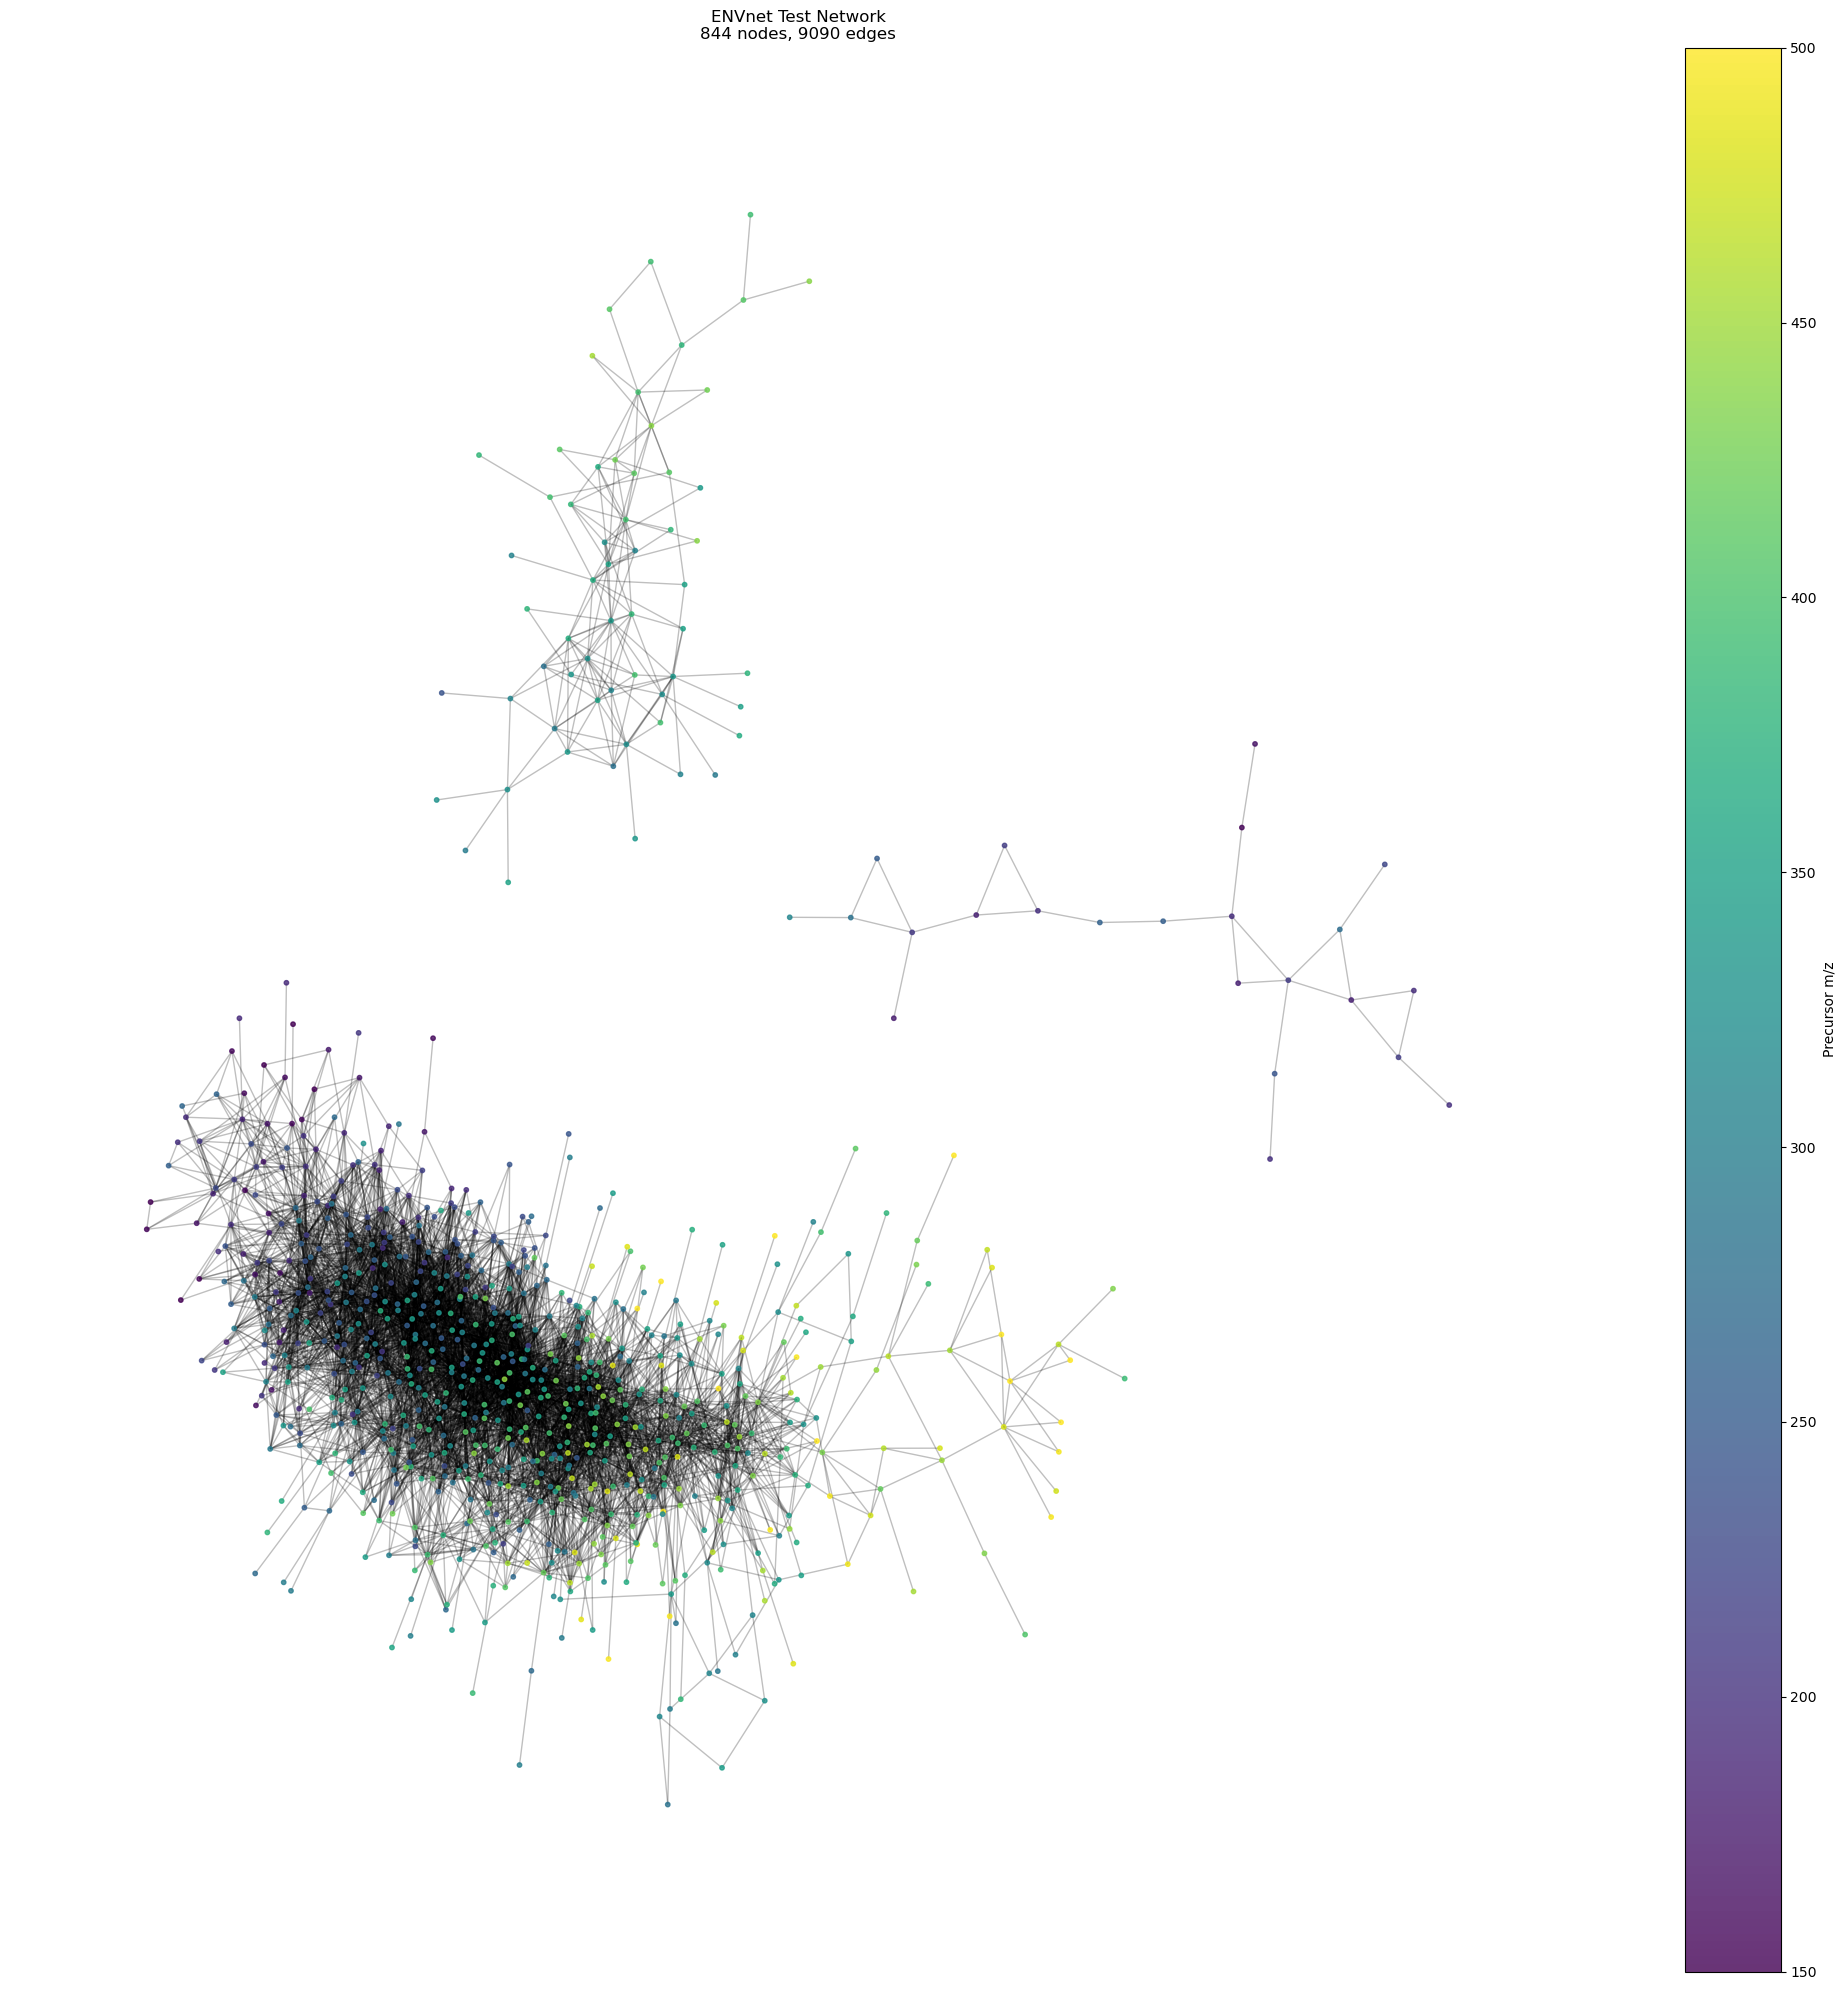

In [ ]:
# plt.figure(figsize=(20, 20))
# if network.number_of_nodes() > 0:
#     # pos = nx.spring_layout(network, k=2, iterations=500)
#     pos = nx.nx_agraph.graphviz_layout(network, prog='neato')

#     # Draw nodes colored by precursor m/z
#     node_colors = [network.nodes[node].get('precursor_mz', 0) for node in network.nodes()]
    
#     nodes = nx.draw_networkx_nodes(network, pos, 
#                             node_color=node_colors, 
#                             node_size=10,
#                             cmap='viridis',
#                             alpha=0.8,
#                             vmin=150,
#                             vmax=500)
    
#     nx.draw_networkx_edges(network, pos, alpha=0.25, width=1)
    
#     # Add labels with m/z values
#     # labels = {node: f"{network.nodes[node].get('precursor_mz', 0):.4f}" 
#     #             for node in network.nodes()}
#     # nx.draw_networkx_labels(network, pos, labels, font_size=8)
    
#     plt.colorbar(nodes, label='Precursor m/z')

#     plt.title(f"ENVnet Test Network\n{network.number_of_nodes()} nodes, {network.number_of_edges()} edges")
    
# else:
#     plt.text(0.5, 0.5, "No network generated", 
#             horizontalalignment='center', verticalalignment='center')
#     plt.title("ENVnet Test - No Network")

# plt.axis('off')
# plt.tight_layout()
# plt.show()

